# 0005.0000b Modeling Strategy b

In [1]:
import pathlib
import sys
import inspect
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))
%aimport
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2009-2010.csv'
fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'

Modules to reload:
all-except-skipped

Modules to skip:



## Modeling Strategy

1. Review Starting Data, Directory Structure

2. Prepare for Modeling, Add some Features, Place into "featured" Directory 

3. Review the Features

4. Transform the Data from Time-Series to Supervised

5. Review the Transformed Data

6. Model the Transformed Data

7. Score the Model with various parameters

8. Calculate the betting return

## 1. Review Starting Data, Directory Structure

A sample directory is set up which contains a subset of the data

The directory is shown below

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!rm -rf $SAMP_FEATURED_SUBDIRS
!rm -rf $SAMP_TRANSFORMED_SUBDIRS
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
├── 03-transformed
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   └── 2007-2008__2017-2018.csv
└── models
    └── optimized-model.joblib

7 directories, 4 files


In [4]:
df_season_stacked = pd.read_csv(SAMP_STACKED_FP,
                                parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_season_stacked.shape

(3366, 94)

DataFrame is a bit difficult to read because it is so wide

It contains some additional columns that we are not using in this particular analysis such as asian odds and Goal difference odds.

These are dropped and the Dataframe is put into a clearer order using a utility function `clean_df`

In [5]:
df_season_stacked = clean_df(df_season_stacked)
df_season_stacked.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,h_corners,h_fouls,h_ftGoals,h_htGoals,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,a_corners,a_fouls,a_ftGoals,a_htGoals,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOddsBbMax,awinOddsBbMean,awinOddsBet365,awinOddsBwa,drawOddsBbMax,drawOddsBbMean,drawOddsBet365,drawOddsBwa,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBet365,hwinOddsBwa
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,9.0,19.0,2.0,0.0,0.0,16.0,7.0,4.0,0.0,23.0,2.0,1.0,0.0,10.0,4.0,3.0,3.20,2.92,2.87,2.85,3.30,3.18,3.25,3.20,2.55,2.30,2.37,2.30
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,4.0,14.0,3.0,1.0,0.0,27.0,13.0,0.0,1.0,13.0,0.0,0.0,0.0,6.0,0.0,3.0,21.00,13.40,19.00,12.25,6.80,5.89,6.00,6.75,1.20,1.18,1.16,1.15
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,7.0,15.0,2.0,0.0,0.0,17.0,4.0,1.0,6.0,17.0,2.0,2.0,0.0,20.0,9.0,2.0,2.22,1.99,2.05,1.90,3.40,3.24,3.30,3.25,3.75,3.44,3.50,3.70
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,6.0,13.0,1.0,1.0,0.0,19.0,5.0,2.0,5.0,13.0,0.0,0.0,0.0,10.0,3.0,1.0,3.30,2.86,2.90,2.85,3.30,3.18,3.20,3.20,2.50,2.33,2.37,2.30
4,germany,bundesliga,2007-2008,hannover,hamburger-sv,2007-08-11,0.0,1.0,awin,6.0,20.0,0.0,0.0,0.0,10.0,2.0,3.0,4.0,18.0,1.0,1.0,0.0,14.0,8.0,1.0,2.85,2.60,2.75,2.60,3.25,3.17,3.20,3.05,2.80,2.55,2.50,2.60


## 2. Prepare for Modeling, Add Some Features, Place into "featured" Directory

#### Utilities

+ One hot encode the results column
+ Make a generic Odds Column - hwinOdds, drawOdds, AwinOdds using Bet365 data
+ Add a game day to use in splitting the season for modeling
    + Walk through each game day
    + Games before game daya are used as features
    + game day games are predicted on by the model
+ Add a marker to show the percentile of the season completed

#### Features

+ Run a Poisson Regression through the season, using historical goals scored as inputs

This is acheived using the src code, which is not shown in this Notebook

The src code runs by moving data through a series of defined directories - defined as constants

We override the directory constants below, so we can run the code on the sample directories


In [6]:
from src.data import stacked_to_ts_featured as sttf
sttf.STACKED_DIR = SAMP_STACKED_DIR
sttf.FEATURED_DIR = SAMP_FEATURED_DIR
sttf.apply_ts_features()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:428: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: divide by zero en

1


## 3. Review the Features

In [7]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   └── 2007-2008__2017-2018.csv
└── models
    └── optimized-model.joblib

9 directories, 5 files


In [8]:
df_featured = pd.read_csv(SAMP_FEATURED_FP,
                          parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_featured.shape

(3366, 55)

In [9]:
df_featured.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,implied_hwin,implied_draw,implied_awin,h_impliedWin,h_impliedDraw,h_impliedLose,a_impliedWin,a_impliedDraw,a_impliedLose,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,h_corners,h_fouls,h_htGoals,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,a_corners,a_fouls,a_htGoals,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,0.391387,0.285412,0.323201,0.391387,0.285412,0.323201,0.323201,0.285412,0.391387,2,0,1,0,0.003268,9.0,19.0,0.0,NaN,NaN,NaN,0.0,16.0,7.0,4.0,0.0,23.0,1.0,NaN,NaN,NaN,0.0,10.0,4.0,3.0,2.87,3.20,2.92,2.85,3.25,3.30,3.18,3.20,2.37,2.55,2.30,2.30
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,0.797203,0.154126,0.048671,0.797203,0.154126,0.048671,0.048671,0.154126,0.797203,1,1,0,0,0.022876,4.0,14.0,1.0,NaN,NaN,NaN,0.0,27.0,13.0,0.0,1.0,13.0,0.0,NaN,NaN,NaN,0.0,6.0,0.0,3.0,19.00,21.00,13.40,12.25,6.00,6.80,5.89,6.75,1.16,1.20,1.18,1.15
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,0.265398,0.281483,0.453119,0.265398,0.281483,0.453119,0.453119,0.281483,0.265398,2,0,1,0,0.022876,7.0,15.0,0.0,NaN,NaN,NaN,0.0,17.0,4.0,1.0,6.0,17.0,2.0,NaN,NaN,NaN,0.0,20.0,9.0,2.0,2.05,2.22,1.99,1.90,3.30,3.40,3.24,3.25,3.50,3.75,3.44,3.70
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,0.390951,0.289548,0.319501,0.390951,0.289548,0.319501,0.319501,0.289548,0.390951,1,1,0,0,0.022876,6.0,13.0,1.0,NaN,NaN,NaN,0.0,19.0,5.0,2.0,5.0,13.0,0.0,NaN,NaN,NaN,0.0,10.0,3.0,1.0,2.90,3.30,2.86,2.85,3.20,3.30,3.18,3.20,2.37,2.50,2.33,2.30
4,germany,bundesliga,2007-2008,hannover,hamburger-sv,2007-08-11,0.0,1.0,awin,0.371700,0.290391,0.337909,0.371700,0.290391,0.337909,0.337909,0.290391,0.371700,3,0,0,1,0.022876,6.0,20.0,0.0,NaN,NaN,NaN,0.0,10.0,2.0,3.0,4.0,18.0,1.0,NaN,NaN,NaN,0.0,14.0,8.0,1.0,2.75,2.85,2.60,2.60,3.20,3.25,3.17,3.05,2.50,2.80,2.55,2.60


In [10]:
df_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 55 columns):
nation              3366 non-null object
league              3366 non-null object
season              3366 non-null object
h                   3366 non-null object
a                   3366 non-null object
date                3366 non-null datetime64[ns]
h_ftGoals           3366 non-null float64
a_ftGoals           3366 non-null float64
result              3366 non-null object
implied_hwin        3366 non-null float64
implied_draw        3366 non-null float64
implied_awin        3366 non-null float64
h_impliedWin        3366 non-null float64
h_impliedDraw       3366 non-null float64
h_impliedLose       3366 non-null float64
a_impliedWin        3366 non-null float64
a_impliedDraw       3366 non-null float64
a_impliedLose       3366 non-null float64
ordinal_result      3366 non-null int64
ordinal_result_1    3366 non-null int64
ordinal_result_2    3366 non-null int64
ordinal_result_3

We want our poisson regression probabailities to be tretaed as features when we transform the data.

The code treats a column as a feature if it is prefixed by `h_` or `a_`

Therefore we need to add this prefix

In the production version of the PoissonRegression Classifier these prefixed columns will be returned

We gave 3 probabilities associated with 2 teams. One of the probabilities applies to both team - the draw probability - Explain here !!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

therefore, we will end up with each team having 2 probabilities as features - win and draw - enumerated below

Home Team
+ p(win) h_poissWin
+ p(draw) h_poissDraw
+ p(lose) h_poissLose

Away Team
+ p(win) a_poissWin
+ p(draw) a_poissDraw
+ p(lose) a_poissLose


## 4. Transform the Featured Data from Time-Series to Supervised


The source code is built to run on specific directories e.g. FEATURED_DIR, TRANSFORMED_DIR - see below - these are python CONSTANTS

We will override these constants so we can use the same module on our sample data

Below, we can see the main function we will run on the dataframe we created above

The function that does the work is transform_ts_to_supervised

In [11]:
from src.data import transform_long_to_wide
transform_long_to_wide.FEATURED_DIR = SAMP_FEATURED_DIR
transform_long_to_wide.TRANSFORMED_DIR = SAMP_TRANSFORMED_DIR

In [12]:
run_transform_ts_to_supervised()

1


In [13]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   └── 2007-2008__2017-2018.csv
└── models
    └── optimized-model.joblib

11 directories, 6 files


# 5. Review the Transformed Data

In [411]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [412]:
df_trans.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_impliedDraw-0,a_a_impliedDraw-1,a_a_impliedDraw-2,a_a_impliedDraw-3,a_a_impliedDraw-4,a_a_impliedDraw-5,a_a_impliedDraw-6,a_a_impliedDraw-7,a_a_impliedDraw-8,a_a_impliedDraw-9,a_a_impliedDraw-10,a_a_impliedDraw-11,a_a_impliedDraw-12,a_a_impliedDraw-13,a_a_impliedDraw-14,a_a_impliedDraw-15,a_a_impliedDraw-16,a_a_impliedLose-0,a_a_impliedLose-1,a_a_impliedLose-2,a_a_impliedLose-3,a_a_impliedLose-4,a_a_impliedLose-5,a_a_impliedLose-6,a_a_impliedLose-7,a_a_impliedLose-8,a_a_impliedLose-9,a_a_impliedLose-10,a_a_impliedLose-11,a_a_impliedLose-12,a_a_impliedLose-13,a_a_impliedLose-14,a_a_impliedLose-15,a_a_impliedLose-16,a_a_impliedWin-0,a_a_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-3,a_a_impliedWin-4,a_a_impliedWin-5,a_a_impliedWin-6,a_a_impliedWin-7,a_a_impliedWin-8,a_a_impliedWin-9,a_a_impliedWin-10,a_a_impliedWin-11,a_a_impliedWin-12,a_a_impliedWin-13,a_a_impliedWin-14,a_a_impliedWin-15,a_a_impliedWin-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,...,h_a_yellowCards-6,h_a_yellowCards-7,h_a_yellowCards-8,h_a_yellowCards-9,h_a_yellowCards-10,h_a_yellowCards-11,h_a_yellowCards-12,h_a_yellowCards-13,h_a_yellowCards-14,h_a_yellowCards-15,h_a_yellowCards-16,h_a_yellowCards-17,h_h_corners-0,h_h_corners-1,h_h_corners-2,h_h_corners-3,h_h_corners-4,h_h_corners-5,h_h_co

We have these historical features for each team playing a match

So, consider a mtach being played today

To get the **number of goals** scored by the **home team** in the **last 2 games** they played **at home**:
+ h_h_ftGoals-1
+ h_h_ftGoals-2

To get the **number of goals** scored by the **home team** in the **last 3 games** they played **away**:
+ h_a_ftGoals-1
+ h_a_ftGoals-2
+ h_a_ftGoals-3

To get the **poisson regression probability of winning** for the **away team** in the **last (1) game** they played **away**:
+ a_a_poissWin-1

Feature Nomenclature & Time Series to Supervised

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

DataFrame in time sequence where index 0 is the earliest game, and index max is the latest game

There are 2 teams per game `h` and `a`, where h indicates the team played at home, and a - away.

Each team has generated a feature by the end of the game - `h_feat`, and `a_feat`

There could be multiple features, meaning a double  set for each feature

Each team has a home game record and an away game record

So, there are 4 records to get for each feature
+ home team home record `h_h`
+ home team away record `h_a`
+ away team home record `a_h`
+ away team away record `a_a`

Results presented as 0, -1, -2 ... -n where 0 referes to the current game. This column can be used as a predictor variable for classification, or used as a classification response, or dropped and just the previous game features used for prediction

### Interpretation Note

`h_h_feat_-1` means:
+ (`h`) home team 
+ (`h`) home game records 
+ (`feat`) feature value in 
+ (`-1`) last game


In [413]:
df_trans.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,a_a_corners-0,a_a_corners-1,a_a_corners-2,a_a_corners-3,a_a_corners-4,a_a_corners-5,a_a_corners-6,a_a_corners-7,a_a_corners-8,a_a_corners-9,a_a_corners-10,a_a_corners-11,a_a_corners-12,a_a_corners-13,a_a_corners-14,a_a_corners-15,a_a_corners-16,a_a_fouls-0,a_a_fouls-1,a_a_fouls-2,a_a_fouls-3,a_a_fouls-4,a_a_fouls-5,a_a_fouls-6,a_a_fouls-7,a_a_fouls-8,a_a_fouls-9,a_a_fouls-10,a_a_fouls-11,a_a_fouls-12,a_a_fouls-13,a_a_fouls-14,a_a_fouls-15,a_a_fouls-16,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_htGoals-0,a_a_htGoals-1,a_a_htGoals-2,a_a_htGoals-3,a_a_htGoals-4,a_a_htGoals-5,a_a_htGoals-6,a_a_htGoals-7,a_a_htGoals-8,a_a_htGoals-9,a_a_htGoals-10,a_a_htGoals-11,a_a_htGoals-12,a_a_htGoals-13,a_a_htGoals-14,a_a_htGoals-15,a_a_htGoals-16,a_a_impliedDraw-0,a_a_impliedDraw-1,a_a_impliedDraw-2,a_a_impliedDraw-3,a_a_impliedDraw-4,a_a_impliedDraw-5,a_a_impliedDraw-6,a_a_impliedDraw-7,a_a_impliedDraw-8,a_a_impliedDraw-9,a_a_impliedDraw-10,a_a_impliedDraw-11,a_a_impliedDraw-12,a_a_impliedDraw-13,a_a_impliedDraw-14,a_a_impliedDraw-15,a_a_impliedDraw-16,a_a_impliedLose-0,a_a_impliedLose-1,a_a_impliedLose-2,a_a_impliedLose-3,a_a_impliedLose-4,a_a_impliedLose-5,a_a_impliedLose-6,a_a_impliedLose-7,a_a_impliedLose-8,a_a_impliedLose-9,a_a_impliedLose-10,a_a_impliedLose-11,a_a_impliedLose-12,a_a_impliedLose-13,a_a_impliedLose-14,a_a_impliedLose-15,a_a_impliedLose-16,a_a_impliedWin-0,a_a_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-3,a_a_impliedWin-4,a_a_impliedWin-5,a_a_impliedWin-6,a_a_impliedWin-7,a_a_impliedWin-8,a_a_impliedWin-9,a_a_impliedWin-10,a_a_impliedWin-11,a_a_impliedWin-12,a_a_impliedWin-13,a_a_impliedWin-14,a_a_impliedWin-15,a_a_impliedWin-16,a_a_poissDraw-0,a_a_poissDraw-1,a_a_poissDraw-2,a_a_poissDraw-3,a_a_poissDraw-4,a_a_poissDraw-5,a_a_poissDraw-6,a_a_poissDraw-7,a_a_poissDraw-8,a_a_poissDraw-9,a_a_poissDraw-10,a_a_poissDraw-11,a_a_poissDraw-12,a_a_poissDraw-13,a_a_poissDraw-14,a_a_poissDraw-15,a_a_poissDraw-16,a_a_poissLose-0,a_a_poissLose-1,a_a_poissLose-2,a_a_poissLose-3,a_a_poissLose-4,a_a_poissLose-5,a_a_poissLose-6,a_a_poissLose-7,a_a_poissLose-8,a_a_poissLose-9,a_a_poissLose-10,a_a_poissLose-11,a_a_poissLose-12,a_a_poissLose-13,a_a_poissLose-14,a_a_poissLose-15,a_a_poissLose-16,a_a_poissWin-0,a_a_poissWin-1,a_a_poissWin-2,a_a_poissWin-3,a_a_poissWin-4,a_a_poissWin-5,a_a_poissWin-6,a_a_poissWin-7,a_a_poissWin-8,a_a_poissWin-9,a_a_poissWin-10,a_a_poissWin-11,a_a_poissWin-12,a_a_poissWin-13,a_a_poissWin-14,a_a_poissWin-15,a_a_poissWin-16,a_a_redCards-0,a_a_redCards-1,a_a_redCards-2,a_a_redCards-3,a_a_redCards-4,a_a_redCards-5,a_a_redCards-6,a_a_redCards-7,a_a_redCards-8,a_a_redCards-9,a_a_redCards-10,a_a_redCards-11,a_a_redCards-12,a_a_redCards-13,a_a_redCards-14,a_a_redCards-15,a_a_redCards-16,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,...,h_a_yellowCards-6,h_a_yellowCards-7,h_a_yellowCards-8,h_a_yellowCards-9,h_a_yellowCards-10,h_a_yellowCards-11,h_a_yellowCards-12,h_a_yellowCards-13,h_a_yellowCards-14,h_a_yellowCards-15,h_a_yellowCards-16,h_a_yellowCards-17,h_h_corners-0,h_h_corners-1,h_h_corners-2,h_h_corners-3,h_h_corners-4,h_h_corners-5,h_h_co

## 6. Stack All Data for Modeling

In [414]:
df_trans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 1007 columns):
nation                  3366 non-null object
league                  3366 non-null object
season                  3366 non-null object
h                       3366 non-null object
a                       3366 non-null object
date                    3366 non-null datetime64[ns]
h_ftGoals               3366 non-null float64
a_ftGoals               3366 non-null float64
result                  3366 non-null object
a_corners               3366 non-null float64
a_fouls                 3366 non-null float64
a_htGoals               3366 non-null float64
a_impliedDraw           3366 non-null float64
a_impliedLose           3366 non-null float64
a_impliedWin            3366 non-null float64
a_poissDraw             3083 non-null float64
a_poissLose             3083 non-null float64
a_poissWin              3083 non-null float64
a_redCards              3366 non-null float64
a_shots         

As the season progresses, more historical data becomes available, which is seen in the missing data plot below

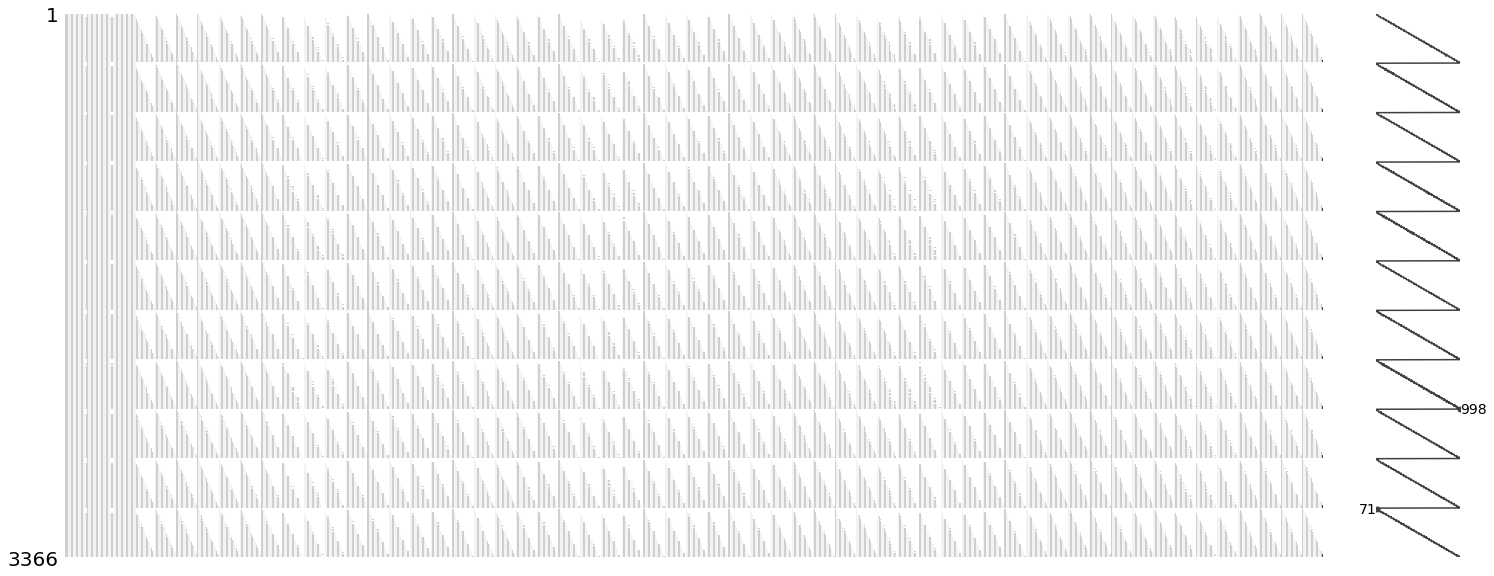

In [415]:
msno.matrix(df_trans)
plt.show();

Reviewing a single feature

As the season progresses, more historical data builds up, and the row fills in

Note thgat the suffix `_0` applies to the current game, so we need to drop these `0` columns prior to modeling

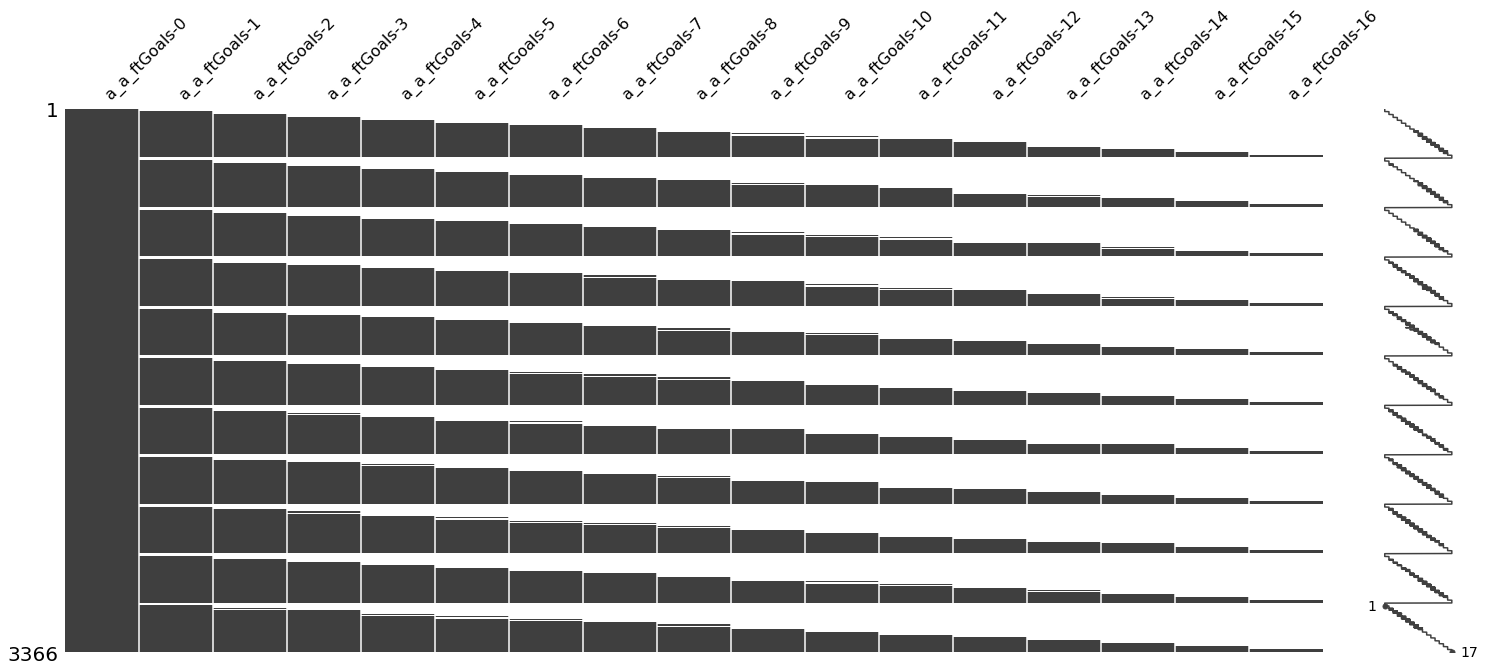

In [416]:
feat_cols = [col for col in df_trans.columns if 'a_a_ftGoals' in col]
msno.matrix(df_trans[feat_cols])
plt.show();

## 6. Select, Impute, Compress the Features

In [417]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

#### Nomenclature

+ base_feature - ftGoals, htGoals, ...
+ feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
+ feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [418]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [419]:
# selected_base_features = base_features
# # selected_base_features = ['impliedWin', 'impliedDraw', 'impliedLose', 'poissWin', 'poissDraw', 'poissLose']#  base_features
# # selected_base_features = ['impliedWin', 'impliedDraw', 'impliedLose']#  base_features
selected_base_features = ['impliedWin']#  base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_impliedWin-6,a_h_impliedWin-6,h_a_impliedWin-6,h_h_impliedWin-6,a_a_impliedWin-7,a_h_impliedWin-7,h_a_impliedWin-7,h_h_impliedWin-7,a_a_impliedWin-8,a_h_impliedWin-8,h_a_impliedWin-8,h_h_impliedWin-8,a_a_impliedWin-9,a_h_impliedWin-9,h_a_impliedWin-9,h_h_impliedWin-9,a_a_impliedWin-10,a_h_impliedWin-10,h_a_impliedWin-10,h_h_impliedWin-10,a_a_impliedWin-11,a_h_impliedWin-11,h_a_impliedWin-11,h_h_impliedWin-11,a_a_impliedWin-12,a_h_impliedWin-12,h_a_impliedWin-12,h_h_impliedWin-12,a_a_impliedWin-13,a_h_impliedWin-13,h_a_impliedWin-13,h_h_impliedWin-13,a_a_impliedWin-14,a_h_impliedWin-14,h_a_impliedWin-14,h_h_impliedWin-14,a_a_impliedWin-15,a_h_impliedWin-15,h_a_impliedWin-15,h_h_impliedWin-15,a_a_impliedWin-16,a_h_impliedWin-16,h_a_impliedWin-16,h_h_impliedWin-16,a_h_impliedWin-17,h_a_impliedWin-17
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,0.0,23.0,1.0,0.285412,0.391387,0.323201,NaN,NaN,NaN,0.0,10.0,4.0,3.0,2.87,3.20,2.92,2.85,3.25,3.30,3.18,3.20,9.0,19.0,0.0,0.285412,0.323201,0.391387,NaN,NaN,NaN,0.0,16.0,7.0,4.0,2.37,2.55,2.30,2.30,0.323201,0.285412,0.391387,2,0,1,0,0.003268,0.323201,0.391387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,1.0,13.0,0.0,0.154126,0.797203,0.048671,NaN,NaN,NaN,0.0,6.0,0.0,3.0,19.00,21.00,13.40,12.25,6.00,6.80,5.89,6.75,4.0,14.0,1.0,0.154126,0.048671,0.797203,NaN,NaN,NaN,0.0,27.0,13.0,0.0,1.16,1.20,1.18,1.15,0.048671,0.154126,0.797203,1,1,0,0,0.022876,0.048671,0.797203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,germany,bundesliga,2007-2008,bochum,sv-werder-bremen,2007-08-11,2.0,2.0,draw,6.0,17.0,2.0,0.281483,0.265398,0.453119,NaN,NaN,NaN,0.0,20.0,9.0,2.0,2.05,2.22,1.99,1.90,3.30,3.40,3.24,3.25,7.0,15.0,0.0,0.281483,0.453119,0.265398,NaN,NaN,NaN,0.0,17.0,4.0,1.0,3.50,3.75,3.44,3.70,0.453119,0.281483,0.265398,2,0,1,0,0.022876,0.453119,0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hertha-berlin,2007-08-11,1.0,0.0,hwin,5.0,13.0,0.0,0.289548,0.390951,0.319501,NaN,NaN,NaN,0.0,10.0,3.0,1.0,2.90,3.30,2.86,2.85,3.20,3.30,3.18,3.20,6.0,13.0,1.0,0.289548,0.319501,0.390951,NaN,NaN,NaN,0.0,19.0,5.0,2.0,2.37,2.50,2.33,2.30,0.319501,0.289548,0.390951,1,1,0,0,0.022876,0.319501,0.390951,NaN,NaN,NaN,NaN,Na

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [420]:
n_back=2
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2
0,germany,bundesliga,2007-2008,dortmund,sv-werder-bremen,2007-09-14,3.0,0.0,hwin,3.0,17.0,0.0,0.289544,0.361930,0.348525,0.222188,0.343566,0.434241,1.0,13.0,4.0,4.0,2.70,2.80,2.63,2.55,3.25,3.35,3.22,3.2,6.0,28.0,3.0,0.289544,0.348525,0.361930,0.222188,0.434241,0.343566,0.0,6.0,5.0,2.0,2.60,2.75,2.55,2.55,0.348525,0.289544,0.361930,1,1,0,0,0.120915,0.348525,0.361930,0.357143,0.589005,0.422936,0.574729,0.453119,0.243889,0.195643,0.603270,0.357143,0.589005,0.422936,0.574729,0.453119,0.243889,0.195643,0.603270
1,germany,bundesliga,2007-2008,bayern-munich,schalke,2007-09-15,1.0,1.0,draw,7.0,17.0,1.0,0.234783,0.626087,0.139130,0.057567,0.923222,0.017951,0.0,12.0,5.0,1.0,6.75,6.75,5.87,5.70,4.00,4.00,3.65,3.6,6.0,21.0,0.0,0.234783,0.139130,0.626087,0.057567,0.017951,0.923222,0.0,14.0,6.0,1.0,1.50,1.62,1.55,1.55,0.139130,0.234783,0.626087,2,0,1,0,0.140523,0.139130,0.626087,0.441735,0.539510,0.504959,0.796308,0.323201,0.531032,0.475270,0.797203,0.441735,0.539510,0.504959,0.796308,0.323201,0.531032,0.475270,0.797203
2,germany,bundesliga,2007-2008,bielefeld,hansa-rostock,2007-09-15,4.0,2.0,hwin,1.0,22.0,0.0,0.267606,0.535211,0.197183,0.151834,0.829690,0.018467,0.0,9.0,5.0,1.0,4.75,5.05,4.57,4.45,3.50,3.60,3.38,3.3,4.0,18.0,1.0,0.267606,0.197183,0.535211,0.151834,0.018467,0.829690,0.0,14.0,7.0,0.0,1.75,1.85,1.74,1.75,0.197183,0.267606,0.535211,1,1,0,0,0.140523,0.197183,0.535211,0.195359,0.290769,0.309845,0.391387,0.048671,0.357143,0.257009,0.441735,0.195359,0.290769,0.309845,0.391387,0.048671,0.357143,0.257009,0.441735
3,germany,bundesliga,2007-2008,eintracht-frankfurt,hamburger-sv,2007-09-15,2.0,1.0,hwin,10.0,18.0,0.0,0.289544,0.348525,0.361930,0.354313,0.224404,0.421283,0.0,17.0,7.0,4.0,2.60,2.65,2.53,2.50,3.25,3.30,3.20,3.2,3.0,21.0,1.0,0.289544,0.361930,0.348525,0.354313,0.421283,0.224404,0.0,16.0,4.0,1.0,2.70,2.90,2.62,2.60,0.361930,0.289544,0.348525,1,1,0,0,0.140523,0.361930,0.348525,0.404145,0.231019,0.154123,0.539510,0.337909,0.441735,0.272836,0.390951,0.404145,0.231019,0.154123,0.539510,0.337909,0.441735,0.272836,0.390951
4,germany,bundesliga,2007-2008,leverkusen,bochum,2007-09-15,2.0,0.0,hwin,9.0,21.0,0.0,0.249314,0.580700,0.169987,0.138022,0.764878,0.096902,1.0,11.0,4.0,1.0,5.50,5.65,5.07,4.60,3.75,3.80,3.51,3.4,8.0,18.0,0.0,0.249314,0.169987,0.580700,0.138022,0.096902,0.764878,0.0,21.0,4.0,2.0,1.61,1.73,1.65,1.70,0.169987,0.249314,0.580700,1,1,0,0,0.140523,0.169987,0.580700,0.257009,0.309845,0.195359,0.589005,0.323341,0.265398,0.272836,0.603270,0.257009,0.309845,0.195359,0.589005,0.323341,0.265398,0.272836,0.603270


In [421]:
df_cut.shape

(2954, 73)

### Compress Feature Space

In [422]:
df_compress = df_cut.copy(deep=True)

def compress_all_features(df_orig, func='mean'):
    df = df_orig.copy(deep=True)
    feature_name_stubs = get_feature_name_stubs_from_base(df, selected_base_features)
    for feature_name_stub in feature_name_stubs:
        cols = [col for col in df.columns if '-' in col and feature_name_stub == col.rsplit('-',1)[0]]
        df[feature_name_stub + '-agg'] = df[cols].agg(func=func, axis=1)
        df.drop(columns = cols, inplace=True)
    return df

def drop_unused_features(df_orig):
    df = df_orig.copy(deep=True)
    redundant_features = [col for col in df.columns if 'agg' not in col and (col[0:2] =='h_' or col[0:2] == 'a_')]
    df.drop(columns=redundant_features, inplace=True)
    return df
    

# compressed_df = compress_all_features(df_compress, func='mean')
# compressed_df2 = drop_unused_features(compressed_df)
# compressed_df2.head()
compressed_df2 = df_compress

In [423]:
compressed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2954 entries, 0 to 2953
Data columns (total 73 columns):
nation              2954 non-null object
league              2954 non-null object
season              2954 non-null object
h                   2954 non-null object
a                   2954 non-null object
date                2954 non-null datetime64[ns]
h_ftGoals           2954 non-null float64
a_ftGoals           2954 non-null float64
result              2954 non-null object
a_corners           2954 non-null float64
a_fouls             2954 non-null float64
a_htGoals           2954 non-null float64
a_impliedDraw       2954 non-null float64
a_impliedLose       2954 non-null float64
a_impliedWin        2954 non-null float64
a_poissDraw         2953 non-null float64
a_poissLose         2953 non-null float64
a_poissWin          2953 non-null float64
a_redCards          2954 non-null float64
a_shots             2954 non-null float64
a_shotsOnTarget     2954 non-null float64
a_yellowCa

## 7. Modeling

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [424]:
df_model = compressed_df2.copy(deep=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBbMax,awinOddsBbMean,awinOddsBwa,drawOdds,drawOddsBbMax,drawOddsBbMean,drawOddsBwa,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBbMax,hwinOddsBbMean,hwinOddsBwa,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile
0,germany,bundesliga,2007-2008,dortmund,sv-werder-bremen,2007-09-14,3.0,0.0,hwin,3.0,17.0,0.0,0.289544,0.361930,0.348525,0.222188,0.343566,0.434241,1.0,13.0,4.0,4.0,2.70,2.80,2.63,2.55,3.25,3.35,3.22,3.2,6.0,28.0,3.0,0.289544,0.348525,0.361930,0.222188,0.434241,0.343566,0.0,6.0,5.0,2.0,2.6,2.75,2.55,2.55,0.348525,0.289544,0.361930,1,1,0,0,0.120915
1,germany,bundesliga,2007-2008,bayern-munich,schalke,2007-09-15,1.0,1.0,draw,7.0,17.0,1.0,0.234783,0.626087,0.139130,0.057567,0.923222,0.017951,0.0,12.0,5.0,1.0,6.75,6.75,5.87,5.70,4.00,4.00,3.65,3.6,6.0,21.0,0.0,0.234783,0.139130,0.626087,0.057567,0.017951,0.923222,0.0,14.0,6.0,1.0,1.5,1.62,1.55,1.55,0.139130,0.234783,0.626087,2,0,1,0,0.140523


In [425]:
meta.shape

(2954, 55)

In [426]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_a_impliedWin-1,a_h_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-2,a_h_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-1,a_a_impliedWin-1,a_h_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_a_impliedWin-2,a_h_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,h_h_impliedWin-2
0,0.348525,0.361930,0.357143,0.357143,0.589005,0.589005,0.422936,0.422936,0.574729,0.574729,0.453119,0.453119,0.243889,0.243889,0.195643,0.195643,0.603270,0.603270,0.357143,0.357143,0.589005,0.589005,0.422936,0.422936,0.574729,0.574729,0.453119,0.453119,0.243889,0.243889,0.195643,0.195643,0.603270,0.603270
1,0.139130,0.626087,0.441735,0.441735,0.539510,0.539510,0.504959,0.504959,0.796308,0.796308,0.323201,0.323201,0.531032,0.531032,0.475270,0.475270,0.797203,0.797203,0.441735,0.441735,0.539510,0.539510,0.504959,0.504959,0.796308,0.796308,0.323201,0.323201,0.531032,0.531032,0.475270,0.475270,0.797203,0.797203


In [427]:
X.shape

(2954, 34)

In [428]:
y = get_target_df(df_model, format='ordinal_result_columns')
y.head(2)

,ordinal_result_1,ordinal_result_2,ordinal_result_3
0,1,0,0
1,0,1,0


In [429]:
y.shape

(2954, 3)

In [430]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# Split into Train, test, but we will also split the additional data for meta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)
meta_train = meta.loc[y_train.index, :]
meta_test = meta.loc[y_test.index, :]
# print(f'train index:{X_train.index}')
# print(f'meta_train index:{meta_train.index}\n')
# print(f'test index: {y_test.index}')
# print(f'meta test index: {meta_test.index}')
X = X_train.copy(deep=True)
y = y_train.copy(deep=True)

In [431]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import NuSVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
import keras

from src.models.metrics import calc_rps, calc_rps_ss, calc_EVs, select_bets, simulate_betting

In [446]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#from keras.regularizers import kernel_regularizer, activity_regularizer
from keras.regularizers import l1
from keras.optimizers import Adam
model = Sequential()
  
shape1 = X.shape[1]
model.add(Dense(1024, input_shape=(shape1,), activation='relu'))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.10))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(1024, activation='relu'))
  
model.add(Dense(3, activation='softmax'))
  
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print(X.shape)

(1772, 34)


In [447]:
# Train your model on the training data for 2000 epochs
epochs=2000
class_weight=None
class_weight = {0:0.45, 1: 0.275, 2:0.275}
# history = model.fit(X,y, epochs=epochs, validation_split=0.33, class_weight = {0:0.45, 1: 0.275, 2:0.275},
#                     verbose=0, callbacks=[es])
history = model.fit(X_train,y_train, epochs=epochs, validation_split=0.2, class_weight = class_weight,
                    verbose=0, callbacks=[es])
# class_weight: Optional dictionary mapping class indices (integers)
#         to a weight (float) value, used for weighting the loss function
#         (during training only).
# print(history.history)
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])
# print(len(history.history['accuracy']))


Epoch 00025: early stopping
0.51023287
0.4591549336910248


In [330]:
stop

NameError: name 'stop' is not defined

In [ ]:
n_splits = 4

# https://stackoverflow.com/questions/48508036/
# sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul/51795404#51795404
skf = StratifiedKFold(n_splits=n_splits,shuffle=True)
# clf = GaussianNB(priors=[0.45, 0.275, 0.275])
# clf = GaussianNB()
# clf = MultinomialNB(class_prior=[0.45, 0.275, 0.275], alpha=1.0)
# clf = CategoricalNB(class_prior=[0.45, 0.275, 0.275])
# clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
# clf = RandomForestClassifier()
# clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01, max_depth=20) # 0.24
# clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.005, max_depth=20) # 0.29
# clf = LinearDiscriminantAnalysis(priors=[0.45, 0.275, 0.275], solver='eigen', shrinkage='auto')
clf = LogisticRegression(class_weight='balanced', C=0.01, max_iter=1000) # 0.15
# clf = ExtraTreesClassifier(class_weight='balanced', criterion='entropy')
# clf = NuSVC(probability=True, class_weight='balanced',kernel='poly')
# clf = GaussianProcessClassifier(max_iter_predict=200, multi_class='one_vs_rest')
# clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
# clf = DecisionTreeClassifier(class_weight='balanced',)
# clf = MLPClassifier(learning_rate='adaptive', max_iter=1000, activation='tanh', learning_rate_init=0.0001)
# clf = MLPClassifier(hidden_layer_sizes=(100, ),learning_rate='constant', max_iter=1000,
#                     activation='relu', learning_rate_init=0.015)
# clf = QuadraticDiscriminantAnalysis(priors=[0.45, 0.275, 0.275])
# clf = KNeighborsClassifier(n_neighbors=50, weights='uniform')


X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
meta_train = meta_train.reset_index(drop=True)

joined_validate_dfs = []
n = 0
rpss_median_scores = []
for fit_indices, validate_indices in skf.split(X, y):

    X_fit = X.iloc[fit_indices]
    y_fit = y.iloc[fit_indices]
    
    X_validate = X.iloc[validate_indices]
    y_validate = y.iloc[validate_indices]
    
    meta_fit = meta.iloc[fit_indices]
    meta_validate = meta.iloc[validate_indices]
    
    clf.fit(X_fit, y_fit)
    validate_preds = clf.predict_proba(X_validate)
    
    validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index=validate_indices)
    
    df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
    df_validate['model_rps'] = calc_rps(validate_preds_df,
                                        meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])

    df_validate['bookie_rps'] = calc_rps(meta_validate[['implied_hwin', 'implied_draw', 'implied_awin']],
                                         meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    df_validate['rpss'] = calc_rps_ss(df_validate['model_rps'], df_validate['bookie_rps'])
                                  #meta_validate[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
    
    rpss_median_scores.append(df_validate['rpss'].median())    
    
    df_validate['n_fold'] = n
    n += 1
    
    joined_validate_dfs.append(df_validate)




validation_df = pd.concat(joined_validate_dfs, sort=False, axis=0)
rpss_median_scores

In [ ]:
validation_df['rpss'].median()

In [ ]:
validation_df.head()

In [ ]:
validation_df.shape

In [ ]:
joblib.dump(clf, SAMP_MODEL_FP) 

## 8. Simulate Gambling in Test Data

In [ ]:
EV_threshold = 2.0
clf = joblib.load(SAMP_MODEL_FP)
clf

In [ ]:
meta_t = meta_test.copy(deep=True)
X_t = X_test.copy(deep=True)
y_t = y_test.copy(deep=True)

meta_t.reset_index(drop=True, inplace=True)
X_t.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

In [ ]:
test_preds = clf.predict_proba(X_t)
test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)

df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

df_test['model_rps'] = calc_rps(test_preds_df,
                                meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['bookie_rps'] = calc_rps(meta_t[['implied_hwin', 'implied_draw', 'implied_awin']],
                                 meta_t[['ordinal_result_1','ordinal_result_2', 'ordinal_result_3']])
df_test['rpss'] = calc_rps_ss(df_test['model_rps'], df_test['bookie_rps'])

# awinOddsBbMax
df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBbMax']-1)) + ((1- df_test[1]) * -1)
df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBbMax']-1)) + ((1- df_test[2]) * -1)
df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBbMax']-1)) + ((1- df_test[3]) * -1)

EV_threshold = EV_threshold
df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = \
            df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold


conditions = [df_test['ordinal_result_1'] == 1,
              df_test['ordinal_result_1'] == 0]
choices = [(df_test['hwinOddsBbMax']-1)* df_test['hwin_bet'], -1* df_test['hwin_bet']]
df_test['hwin_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_2'] == 1,
              df_test['ordinal_result_2'] == 0]
choices = [(df_test['drawOddsBbMax']-1)* df_test['draw_bet'], -1* df_test['draw_bet']]
df_test['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [df_test['ordinal_result_3'] == 1,
              df_test['ordinal_result_3'] == 0]
choices = [(df_test['awinOddsBbMax']-1)* df_test['awin_bet'], -1* df_test['awin_bet']]
df_test['awin_rets'] = np.select(conditions, choices, default=0)
df_test['game_ret'] = df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)
df_test.head(15)

In [ ]:
print(df_test['hwin_rets'].sum())
print(df_test['draw_rets'].sum())
print(df_test['awin_rets'].sum())
print()
print(f"Total profit/loss: {df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()}")

In [ ]:
print(f"n_bets: {df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")
print(f"n_games: {len(df_test)}")
print(f"Unit Ret per Game: {df_test['game_ret'].sum()/ len(df_test)}")
print(f"Unit Ret per Bet: {df_test['game_ret'].sum()/ df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")

In [ ]:
df_test['rpss'].mean()

In [ ]:
from scipy.stats import norm

def plot_diagnostics(ser, figsize=(12, 8), bins=20):
    """
    Produce a set of residual diagnosos plots similar to statsmodels tome series analysis
    """
       
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    ax1 = axes[0,0]
    ax2 = axes[1,0]
    ax3 = axes[0,1]
    ax4 = axes[1,1]

    # ax1
    ax1.plot(ser,'o')
    ax1.set_title("Line Plot")

    # ax2
    ax2.hist(ser, bins=bins, alpha=0.5, density=True)
    pd.Series(ser).plot(kind="density", ax=ax2, label="data")
    # Fit statsmodels distribution here and plot density
    mu, std = norm.fit(ser)
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p1 = norm.pdf(x, 0, std)
    ax2.plot(x, p1, "k", label="fitted normal: (0, data std)")
    ax2.legend()
    ax2.set_title("Distribution")
    
    # ax3
    ax3.plot(ser, 'o')
    ax3.set_ylim(-2,1)
    
        # ax2
    ax4.set_xlim(-2,1)
    ax4.hist(ser, bins=200, alpha=0.5, density=True)
#     pd.Series(ser).plot(kind="density", ax=ax4, label="data")
#     # Fit statsmodels distribution here and plot density
#     mu, std = norm.fit(ser)
#     xmin, xmax = ax4.get_xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p1 = norm.pdf(x, 0, std)

#     ax4.plot(x, p1, "k", label="fitted normal: (0, data std)")
#     ax4.legend()
#     ax4.set_title("Distribution")
    

    return fig, axes
    

In [ ]:
fig, axes = plot_diagnostics(df_test['rpss'])
plt.show();

In [ ]:
df_play = df_test.copy(deep=True)
df_play_plus = df_play[df_play['rpss'] > 0]
df_play_minus = df_play[df_play['rpss'] <=0]

In [ ]:
df_play_plus[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()

In [ ]:
df_play_minus[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_play['rpss'], df_play['seasonPercentile'] )
plt.show();

In [ ]:
import ptitprince as pt
fig, ax = plt.subplots(figsize=(10,8))
ax = pt.RainCloud(x='pred_result', y='rpss', data=df_play, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=True)
plt.axvline(x=0.0, c='r')
plt.show();
print(f'pred hwin: {df_play["hwin_rets"].sum()}')
print(f'pred draw: {df_play["draw_rets"].sum()}')
print(f'pred awin: {df_play["awin_rets"].sum()}')

In [ ]:
from mlxtend.plotting import category_scatter
#df_play['rpss'], df_play['seasonPercentile'],

fig = category_scatter(x='rpss', y='seasonPercentile', label_col='result', 
                        data=df_play, legend_loc='upper left', alpha=0.3)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
draws = df_play[df_play['pred_result'] == 'draw']
ax.scatter(draws['rpss'], draws['seasonPercentile'] )
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
hwins = df_play[df_play['pred_result'] == 'hwin']
ax.scatter(hwins['rpss'], hwins['seasonPercentile'] )
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
awins = df_play[df_play['pred_result'] == 'awin']
ax.scatter(awins['rpss'], awins['seasonPercentile'] )
plt.show();

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_target=df_play['result'], 
                      y_predicted=df_play['pred_result'], 
                      binary=False)
cm

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()